In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [3]:
# Load the data
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Subsample dataset for faster execution (20% of data)
df = df.sample(frac=0.2, random_state=42)

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df.drop('Date', axis=1, inplace=True)

X = df.drop('RainTomorrow', axis=1)
y = LabelEncoder().fit_transform(df['RainTomorrow'])

# Define columns
categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
binary_cat = ['RainToday']
numerical_cols = [col for col in X.columns if col not in categorical_cols + binary_cat]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('bin', OneHotEncoder(drop='first', sparse_output=False), binary_cat)
    ])

X_processed = preprocessor.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

Saving Weather Data Set.csv to Weather Data Set (1).csv


In [5]:
# KNN model
knn = KNeighborsClassifier()

# Hyperparameter grid
param_grid_knn = {
    'n_neighbors': [5, 7],  # Reduced search space
    'weights': ['uniform'],  # Simplified to one option
    'p': [2]  # Only Euclidean distance
}

# Grid search with parallel processing
grid_knn = GridSearchCV(knn, param_grid_knn, cv=StratifiedKFold(n_splits=3), scoring='f1', n_jobs=-1)
grid_knn.fit(X_train, y_train)

# Best model
best_knn = grid_knn.best_estimator_
print(f'Best Params: {grid_knn.best_params_}')

Best Params: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


CV Accuracy: 0.8329 ± 0.0027
Accuracy: 0.8268
F1: 0.5200
Precision: 0.6500
Recall: 0.4333
AUC: 0.8066


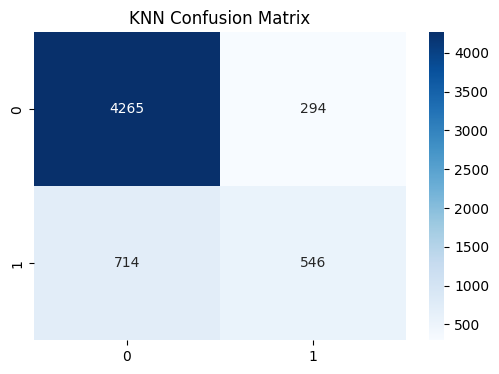

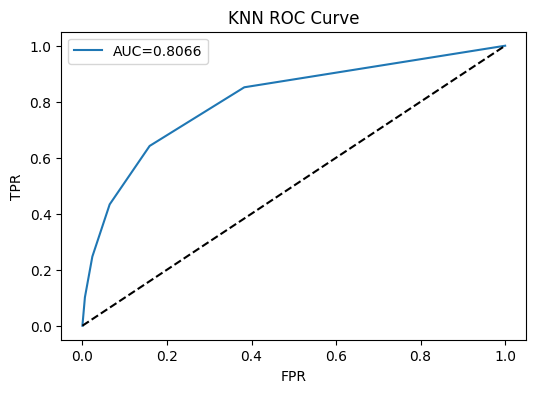

In [6]:
# Cross-validation with fewer folds
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print(f'CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Evaluation metrics
y_pred_knn = best_knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}')
print(f'F1: {f1_score(y_test, y_pred_knn):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_knn):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_knn):.4f}')
print(f'AUC: {roc_auc_score(y_test, best_knn.predict_proba(X_test)[:,1]):.4f}')

# Confusion Matrix
plt.figure(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6,4))
fpr, tpr, _ = roc_curve(y_test, best_knn.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, best_knn.predict_proba(X_test)[:,1]):.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('KNN ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()